This notebook tests the equivalence of original and proposed Linear Gaussian SSM (LGSSM)
posterior inference. See issue #4.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
from functools import partial

import tensorflow_probability.substrates.jax.distributions as tfd
MVN = tfd.MultivariateNormalFullCovariance

import matplotlib.pyplot as plt

from jax_moseq.utils.kalman import ar_to_lds

from jax_moseq.models.slds.gibbs import resample_continuous_stateseqs as proposed_resample_continuous_stateseqs

# from dynamax.linear_gaussian_ssm.inference import (lgssm_posterior_sample,
#                                                    ParamsLGSSM,
#                                                    ParamsLGSSMInitial,
#                                                    ParamsLGSSMDynamics,
#                                                    ParamsLGSSMEmissions,
#                                                   )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# utils

In [2]:
def despine(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [3]:
def random_slds_args(key, num_timesteps, dynamics_eigs, obs_dim, num_lags=1,
                     max_obs_noise_scale=1.0, ):
    """Generate random HMM arguments, log-likelihoods, and masking.

    Observations ys are noisy observations of latent xs.

    Arguments
        num_timesteps (int): number of timesteps in sequence, T
        dynamics_eigs (ndarray): shape [K,D], eigenvalues of K dynamics matrices
        obs_dim (int)
        num_lags (int)
        max_obs_noise_scale (float): 

    Returns
        Ab (ndarray), shape [K,]
    """

    L = num_lags
    K, D = dynamics_eigs.shape

    k1, k2, k3, k4, k5 = jr.split(key, 5)
        
    # Generate transition matrix with specified eigenvalues:
    # - Generate a random orthogonal matrix a
    _P = jr.normal(k1, (K, D, D),)
    _P, _ = jax.vmap(jsp.linalg.qr)(_P)
    
    # - Apply similarity transform
    As = jnp.einsum('klm, kmn -> kln',
                    jax.vmap(jnp.diag)(dynamics_eigs), _P)
    As = jnp.linalg.solve(_P, As)
    As_lag = jnp.concatenate([jnp.tile(jnp.eye(D)*0.01, (K,1,L-1)), As], axis=-1)
    
    bs = jr.normal(k3, (K,D))
    Abs = jnp.concatenate([As_lag, bs[...,None]], axis=-1)
    # Sample remaining LDS parameters
    
    Cd = jr.normal(k4, (obs_dim,D+1))

    # Generate state-specific dynamics noise
    # Overall scale of Q is in 1e0 range. To change the scale of Q to e.g. 1e-4,
    # then sample Q_h from Normal(0, 1e-2)
    Qs = jr.normal(k5, shape=(K,D,D))
    Qs = 0.5 * jnp.einsum('kmn, kln -> kml', Qs, Qs)
    assert jnp.all(jnp.linalg.eigvalsh(Qs) > 0), 'Expecting all Qs to be PSD'

    # R_scales = obs_noise_scale * jr.normal(k5, (num_timesteps, D))
    R_scales = jr.uniform(k5, (num_timesteps, obs_dim),
                          minval=1e-3, maxval=max_obs_noise_scale)

    # Initial parameters
    mu0 = jnp.zeros(D)
    Sigma0 = 10 * jnp.eye(D)
    return Abs, Cd, Qs, R_scales, mu0, Sigma0


def sample_mask(seed, num_timesteps, num_mask):
    mask = jnp.ones(num_timesteps, dtype=int)
    if num_mask > 0:
        i_flip = jr.randint(seed, (num_mask,), 0, num_timesteps)
        mask = mask.at[i_flip].set(0)
    return mask

def slds_sample_obs_and_latents(seed, Abs_arL, Cd_arL, Qs_arL, R_scales, mu0, Sigma0, n_mask=0):
    """
    Parameters
        seed (jr.PRNGKey)
        Abs_arL (array): shape[K, D, D*L+1]
        Cd_arL (array): shape[D_obs, D+1]
        Qs_arL (array): shape[K, D, D*L]
        R_scales (array): shape[T, D_obs]
        mu0 (array): shape[D]
        Sigma0 (array): shape[D,D]

    Returns
    """
    T = R_scales.shape[0]       # num timesteps
    K = Abs_arL.shape[0]        # num states
    D = Abs_arL.shape[-2]       # latent dims
    L = Abs_arL.shape[-1] // D  # num lags
    D_obs = R_scales.shape[-1]

    seed_states, seed_lds, seed_mask = jr.split(seed, 3)

    # ======================
    # Sample discrete states
    zs = jr.randint(seed_states, (T,), minval=0, maxval=K)

    # =============================
    # Sample continous observations
    # Convert L'th-order autoregressive dynamics into 1st order dyanmics
    As, bs, Qs, C, d = ar_to_lds(Abs_arL, Qs_arL, Cd_arL)

    def _step(carry, args):
        x_t = carry
        _seed, A_t, b_t, Q_t, r_t = args

        seed_x, seed_y = jr.split(_seed)

        # Observe
        y_t = MVN(C @ x_t + d, r_t).sample(seed=seed_y)

        # Predict
        m_tp1 = A_t @ x_t + b_t
        x_tp1 = MVN(m_tp1, Q_t).sample(seed=seed_x)

        return x_tp1, (x_tp1, y_t)

    # Roll-out parameters
    As_rollout = As[zs]                                                         # shape (T, D*L, D*L)
    bs_rollout = bs[zs]                                                         # shape (T, D*L)
    Qs_rollout = Qs[zs]                                                         # shape (T, D*L, D*L)
    Rs = jax.vmap(jnp.diag)(R_scales)

    seed_init, seed_tp1 = jr.split(seed_lds)

    x0_LD = MVN(mu0, Sigma0).sample(seed=seed_init, sample_shape=(L,)).reshape(L*D)
    # x_tp1s: shape (T-L-1, D*L)
    _, (x_tp1s, y_ts) = jax.lax.scan(_step, x0_LD,
                                       (jr.split(seed_tp1, T-(L-1)),
                                       As_rollout[L-1:],
                                       bs_rollout[L-1:],
                                       Qs_rollout[L-1:],
                                       Rs[L-1:]))

    # Reformat samples from (D*L)-dim LDS into D-dim LDS
    xs = jnp.concatenate([
        x0_LD[0:L*D].reshape(-1, D),      # x[0:L]
        x_tp1s[:-1,-D:],                  # x[L:T]
    ], axis=0)

    y0_Lm1 = jnp.einsum('YD, LD -> LY', Cd_arL[:,:-1], xs[:L-1])
    ys = jnp.concatenate([y0_Lm1.reshape(-1, D_obs), y_ts], axis=0)

    # Sample mask
    mask = sample_mask(seed, T, n_mask)

    return ys, xs, zs, mask


# LGSSM posterior inference function implementations

## Original moseq implementation
Formerly in [`jax_moseq.utils.kalman` module](https://github.com/dattalab/jax-moseq/blob/65f6f6fc1702a8d1b523ba2150c341aa7df1e2a3/jax_moseq/utils/kalman.py#L10-L53).

In [4]:
from jax_moseq.utils.autoregression import get_nlags

na = jnp.newaxis


def kalman_filter(ys, mask, zs, m0, S0, A, B, Q, C, D, Rs):
    """
    Run a Kalman filter to produce the marginal likelihood and filtered state 
    estimates. 
    """

    def _predict(m, S, A, B, Q):
        mu_pred = A @ m + B
        Sigma_pred = A @ S @ A.T + Q
        return mu_pred, Sigma_pred

    def _condition_on(m, S, C, D, R, y):
        Sinv = jnp.linalg.inv(S)
        S_cond = jnp.linalg.inv(Sinv + (C.T / R) @ C)
        m_cond = S_cond @ (Sinv @ m + (C.T / R) @ (y-D))
        return m_cond, S_cond
    
    def _step(carry, args):
        m_pred, S_pred = carry
        z, y, R = args

        m_cond, S_cond = _condition_on(
            m_pred, S_pred, C, D, R, y)
        
        m_pred, S_pred = _predict(
            m_cond, S_cond, A[z], B[z], Q[z])
        
        return (m_pred, S_pred), (m_cond, S_cond)
    
    def _masked_step(carry, args):
        m_pred, S_pred = carry
        return (m_pred, S_pred), (m_pred, S_pred)
    
    (m_pred, S_pred),(filtered_ms, filtered_Ss) = jax.lax.scan(
        lambda carry,args: jax.lax.cond(args[0]>0, _step, _masked_step, carry, args[1:]),
        (m0, S0), (mask, zs, ys[:-1], Rs[:-1]))
    
    m_cond, S_cond = jax.lax.cond(
        mask[-1], _condition_on, lambda *args: args[:2],
        m_pred, S_pred, C, D, Rs[-1], ys[-1])
    
    filtered_ms = jnp.concatenate((filtered_ms,m_cond[na]),axis=0)
    filtered_Ss = jnp.concatenate((filtered_Ss,S_cond[na]),axis=0)
    return filtered_ms, filtered_Ss

def kalman_sample(seed, ys, mask, zs, m0, S0, A, B, Q, C, D, Rs):
    
    # run the kalman filter
    filtered_ms, filtered_Ss = kalman_filter(ys, mask, zs, m0, S0, A, B, Q, C, D, Rs)
    
    def _condition_on(m, S, A, B, Qinv, x):
        Sinv = jnp.linalg.inv(S)
        S_cond = jnp.linalg.inv(Sinv + A.T @ Qinv @ A)
        m_cond = S_cond @ (Sinv @ m + A.T @ Qinv @ (x-B))
        return m_cond, S_cond

    def _step(x, args):
        m_pred, S_pred, z, w = args
        m_cond, S_cond = _condition_on(m_pred, S_pred, A[z], B[z], Qinv[z], x)
        L = jnp.linalg.cholesky(S_cond)
        x = L @ w + m_cond
        return x, x
    
    def _masked_step(x, args):
        return x,jnp.zeros_like(x)
    
    # precompute and sample
    Qinv = jnp.linalg.inv(Q)
    samples = jr.normal(seed, filtered_ms[:-1].shape)

    # initialize the last state
    x = jr.multivariate_normal(seed, filtered_ms[-1], filtered_Ss[-1])
    
    # scan (reverse direction)
    args = (mask, filtered_ms[:-1], filtered_Ss[:-1], zs, samples)
    _, xs = jax.lax.scan(lambda carry,args: jax.lax.cond(
        args[0]>0, _step, _masked_step, carry, args[1:]), x, args, reverse=True)
    return jnp.vstack([xs, x])

def resample_continuous_stateseqs(seed, Y, mask, z, s, Ab,
                                  Q, Cd, sigmasq, **kwargs):
    """
    Resamples the latent trajectories `x`.

    Parameters
    ----------
    seed : jr.PRNGKey
        JAX random seed.
    Y : jax array of shape (N, T, obs_dim)
        Observations.
    mask : jax array of shape (N, T)
        Binary indicator for valid frames.
    z : jax_array of shape (N, T - n_lags)
        Discrete state sequences.
    s : jax array of shape (N, T, obs_dim)
        Noise scales.
    Ab : jax array of shape (num_states, latent_dim, ar_dim)
        Autoregressive transforms.
    Q : jax array of shape (num_states, latent_dim, latent_dim)
        Autoregressive noise covariances.
    Cd : jax array of shape (obs_dim, latent_dim + 1)
        Observation transform.
    sigmasq : jax_array of shape obs_dim
        Unscaled noise.
    **kwargs : dict
        Overflow, for convenience.

    Returns
    ------
    x : jax array of shape (N, T, latent_dim)
        Latent trajectories.
    """
    n = Y.shape[0]    # num sessions
    d = Ab.shape[1]   # latent dim
    nlags = Ab.shape[2] // d
    
    # 0. spawn random seed for each session
    rng = jr.split(seed, n)
    
    # 1. Format the time varying parameters
    y = Y[:, nlags-1:]   # first n_lags frames cannot be assigned syllable
    mask = mask[:,nlags-1:-1]
    R = sigmasq * s[:, nlags - 1:]    # scale learned uncertainties
    
    # 2. Reformat the dynamics parameters
    A_, b_, Q_, C_, d_ = ar_to_lds(Ab, Q, Cd)
    
    # 3. Initialize the kalman latent estimates
    mu0 = jnp.zeros(d * nlags)
    S0 = 10 * jnp.eye(d * nlags) # TODO: hard coded constant 10
    
    # 4. Apply vectorized Kalman sample to each session
    in_axes = (0,0,0,0,na,na,na,na,na,na,na,0)
    x = jax.vmap(kalman_sample, in_axes)(
        rng, y, mask, z, mu0, S0,
        A_, b_, Q_, C_, d_, R
    )

    # 5. Reformat back into AR space 
    x = jnp.concatenate([x[:, 0, :-d].reshape(-1, nlags-1 ,d), x[:,:,-d:]],axis=1)
    return x


## Proposed implementation

In [5]:
# def proposed_kalman_sample(seed, ys, mask, zs, m0, S0, A, B, Q, C, D, Rs, latent_dim):
#     """Run forward-filtering and backward-sampling to draw samples from posterior
#     of a 1st-order dynamic system with L'th order autoregressive dynamics. This
#     dimensionality is referred to as `ar_dim` = `latent_dim * lag_order` = D * L.
    
#     Parameters
#     ----------
#         seed: jr.PRNGKey.
#         ys: ndarray with shape [(T-L-1), obs_dim].
#             Continuous observations, minus first L+1 frames.
#         mask: ndarray with shape [(T-L-1)]
#             Indicator of observation validity, minus first L+1 frames and last frame
#         zs: ndarray with shape [T-L].
#             Discrete state sequence, taking values 1,...,K; for timesteps [L,T)
#         mu0: ndarray with shape [ar_dim,].
#             Initial continuous state mean
#         S0: ndarray with shape [ar_dim, ar_dim].
#             Initial continuous state covariance
#         A: ndarray with shape [K, ar_dim, ar_dim].
#             State dynamics matrix
#         B: ndarray with shape [K, ar_dim].
#             State input matrix
#         Q: ndarray with shape [K, ar_dim, ar_dim].
#             State noise matrix
#         C: ndarray with shape [obs_dim, ar_dim].
#             Observation transform matrix
#         D: ndarray with shape [obs_dim,].
#             Observation input matrix
#         Rs: ndarray with shape [(T-L-1), obs_dim].
#             Observation noise scales (diagonal entries of covariance)

#     Returns
#     -------

#     """
#     # Noise scale for masked frames
#     # TODO parameterize
#     MASK_SCALE = 10.

#     ar_dim, obs_dim = A.shape[-1], Rs.shape[-1]

#     initial_params = ParamsLGSSMInitial(mean=m0, cov=S0)

#     # Apply discrete states to dynamics
#     # Roll-out dynamics so that they have leading shape (T-L, ...)
#     # If masked, hold last state, i.e. set dynamics for "unlagged" states to
#     # identity matrix and all other state dynamics to 0:
#     #   eye_zero_order = [[0       ]
#     #                     [  0     ]
#     #                     [   ...  ]
#     #                     [       I]]
#     eye_zero_order = jnp.zeros((ar_dim, ar_dim))
#     eye_zero_order = eye_zero_order.at[-latent_dim:,-latent_dim:].set(jnp.eye(latent_dim))
#     A_roll = jnp.where(mask[:-1,None,None], A[zs], eye_zero_order)
#     b_roll = jnp.where(mask[:-1,None], B[zs], jnp.zeros(ar_dim))
#     Q_roll = jnp.where(mask[:-1,None,None], Q[zs], jnp.eye(ar_dim))             # TODO pass in an "invalid latents" noise

#     dynamics_params=ParamsLGSSMDynamics(
#         weights=A_roll, bias=b_roll, input_weights=jnp.zeros((ar_dim, 0)), cov=Q_roll,
#     )
    
#     # Apply mask to observations
#     # If observation is invalid, then equivalent to super high observation noise
#     Rs_masked = jnp.where(mask[:,None], Rs, MASK_SCALE * jnp.ones(obs_dim))
    
#     # Re-inflate flatted noise matrices, ((T-L-1), D_obs, D_obs)
#     Rs_masked = jax.vmap(jnp.diag)(Rs_masked)
    
#     emissions_params=ParamsLGSSMEmissions(
#         weights=C,
#         bias=D,
#         input_weights=jnp.zeros((obs_dim, 0)),
#         cov=Rs_masked,
#     )

#     # Sample
#     params = ParamsLGSSM(
#         initial=initial_params,
#         dynamics=dynamics_params,
#         emissions=emissions_params,
#     )

#     return lgssm_posterior_sample(seed, params, ys)

In [6]:
# def proposed_resample_continuous_stateseqs(
#     seed, Y, mask, z, obs_noise_scales, Ab, Q, Cd, unscaled_obs_noise, **kwargs):
#     """
#     Resamples the latent trajectories `x`.

#     Parameters
#     ----------
#     seed : jr.PRNGKey
#     Y : jax array of shape (N, T, obs_dim)
#         Observations.
#     mask : jax array of shape (N, T)
#         Binary indicator for valid frames.
#     z : jax_array of shape (N, T-L)
#         Discrete state sequences, for timeframes [L-1, T-1).
#     s : jax array of shape (N, T, obs_dim)
#         Noise scales.
#     Ab : jax array of shape (num_states, latent_dim, D*L+1)
#         Autoregressive transforms.
#     Q : jax array of shape (num_states, latent_dim, latent_dim)
#         Autoregressive noise covariances.
#     Cd : jax array of shape (obs_dim, latent_dim + 1)
#         Observation transform.
#     unscaled_obs_noise : jax array of shape (obs_dim,)
#         Unscaled noise.
#     **kwargs : dict
#         Overflow, for convenience.

#     Returns
#     ------
#     x : jax array of shape (N, T, latent_dim)
#         Latent trajectories.
#     """
#     N = Y.shape[0]    # num sessions
#     D = Ab.shape[1]   # latent dim
#     L = Ab.shape[2] // D
    
#     # 1. Omit first L frames of observations
#     y = Y[:,L-1:]
#     mask = mask[:,L-1:] # CHANGED CHANGED CHANGED, originally mask[:,L-1:-1]. I handle it different in kalman sample than original
#     R = unscaled_obs_noise * obs_noise_scales[:,L-1:]
    
#     # 2. Transform L'th-order AR dynamics parameters in R^D into
#     #    0th-order AR dynamics parameters in R^{D*L}
#     A_, b_, Q_, C_, d_ = ar_to_lds(Ab, Q, Cd)
    
#     # 3. Initialize the kalman latent estimates
#     mu0 = jnp.zeros(D*L)
#     S0 = 10 * jnp.eye(D*L) # TODO: hard coded constant 10
    
#     # 4. Apply vectorized Kalman sample to each session
#     #    Returns x_ld: shape (T, D*L)
#     _proposed_kalman_sample = partial(
#         proposed_kalman_sample,
#         m0=mu0, S0=S0, A=A_, B=b_, Q=Q_, C=C_, D=d_, latent_dim=D,
#     )
#     x_ld = jax.vmap(_proposed_kalman_sample)(jr.split(seed, N), y, mask, z, Rs=R)

#     # 5. Reformat back into D-dimensional latent space
#     x = jnp.concatenate([x_ld[:,0,:(L-1)*D].reshape(-1,L-1,D), x_ld[:,:,-D:]], axis=1)
#     return x

# Evaluate

In [7]:
def get_mean_and_cov(x):
    """Get mean and covariance of sequence shape (N,T,D)."""
    m = x.mean(axis=0)

    
    C = jax.vmap(partial(jnp.cov, rowvar=False), in_axes=1)(x)
    return m, C

def _plot_mean_variance_1d(ax, m, C, dim, color, **kwargs):
    num_timesteps = len(m)

    # Plot mean
    lh, = ax.plot(jnp.arange(num_timesteps), m[:,dim], color=color, **kwargs)
    
    # Plot 2 * stdvs
    err = 2 * jnp.sqrt(C[:,dim,dim])
    ax.fill_between(jnp.arange(num_timesteps), m[:,dim]-err, m[:,dim]+err, color=color, alpha=0.4)
    return lh

def plot_mean_variance(x_original, x_proposed, x_true, mask):
    # Calculate covariance across samples, for each timestep
    get_cov = lambda x: jax.vmap(partial(jnp.cov, rowvar=False), in_axes=1)(x)
    
    # Calculate means and covariances
    x_mean = x_original.mean(axis=0)
    x_cov = get_cov(x_original)

    xp_mean = x_proposed.mean(axis=0)
    xp_cov = get_cov(x_proposed)
    
    # --------------------------------
    latent_dim = x_original.shape[-1]
    num_timesteps = len(mask)

    fig, axs = plt.subplots(nrows=latent_dim, ncols=1, sharey=True,
                        gridspec_kw={'hspace':0.05}, figsize=(7, 2*latent_dim))

    for i, ax in enumerate(axs):
        lh_true, = ax.plot(jnp.arange(num_timesteps), x_true[:,i], 'black', label='true')
        lh_original = _plot_mean_variance_1d(ax, x_mean, x_cov, i, 'C0', label='original')
        lh_proposed = _plot_mean_variance_1d(ax, xp_mean, xp_cov, i, 'C1', label='proposed')
        ax.set_ylabel(f'x{i}')
        despine(ax)

        m1 = None
        for i_mask in jnp.nonzero(1-mask)[0]:
            m1 = ax.axvspan(i_mask-0.5, i_mask+0.5, alpha=0.4, facecolor='black', label='mask')

    handles, labels = [lh_true, lh_original,lh_proposed,m1], ['true', 'original', 'proposed', 'mask']
    if m1 == None:
        handles, labels = handles[:-1], labels[:-1]
    fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=[0.5, 0], ncols=len(labels))

    return fig, axs

In [8]:
def sample_original_vs_proposed(seed,
                                dynamics_eigs_range,
                                num_invalid,
                                num_states=4,
                                latent_dim=3,
                                obs_dim=2,
                                num_lags=3,
                                num_timesteps=50,
                                num_samples=1000,
                                max_obs_noise_scale=1.,
                                mask=None):

    seed_eigs, seed_params, seed_generate, seed_sample = jr.split(seed, 4)

    # Dynamics
    dynamics_eigs = jr.uniform(seed_eigs, (num_states, latent_dim),
                               minval=dynamics_eigs_range[0],
                               maxval=dynamics_eigs_range[1])

    # Generate true parameters and observations
    Abs, Cd, Qs, R_scales, mu0, Sigma0 = \
        random_slds_args(seed_params, num_timesteps, dynamics_eigs, obs_dim, num_lags, max_obs_noise_scale)

    ys, xs, zs, _mask = slds_sample_obs_and_latents(seed_generate, Abs, Cd, Qs, R_scales, mu0, Sigma0, n_mask=num_invalid)
    
    # Use user-specified mask if provided, else use randomly generated mask
    mask = _mask if mask is None else mask

    # Apply mask to preemptively just in case accidentally using this information
    zs_masked = zs * mask
    # ---------------------------------------

    resample_args = (ys[None,], mask[None,], zs_masked[None,num_lags-1:-1], R_scales[None,], Abs, Qs, Cd, jnp.ones(obs_dim))

    in_axes = (0,None,None,None,None,None,None,None,None)
    xs_original = jax.vmap(resample_continuous_stateseqs, in_axes=in_axes)(
                          jr.split(seed_sample, num_samples), *resample_args).squeeze()
    xs_proposed = jax.vmap(proposed_resample_continuous_stateseqs, in_axes=in_axes)(
                           jr.split(seed_sample, num_samples), *resample_args).squeeze()

    # ---------------------------------------    
    
    return xs_original, xs_proposed, (ys, mask), (xs, zs)
    

## No masked observations, stable dynamics

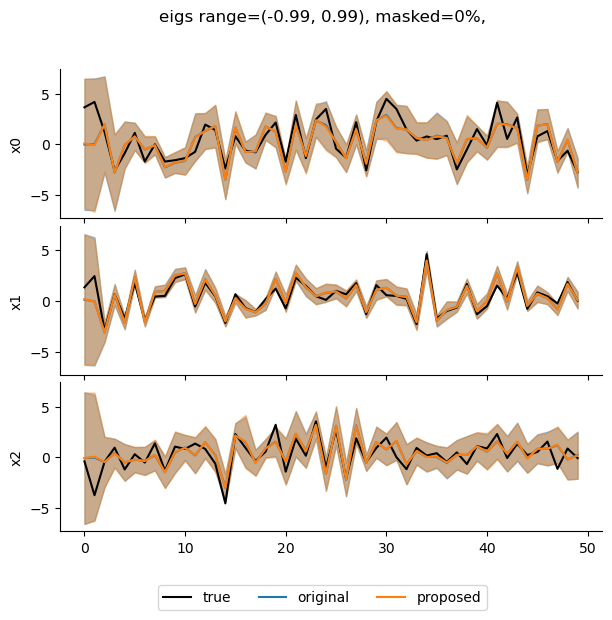

In [9]:
seed = jr.PRNGKey(40192)
num_invalid = 0
num_samples = 1000

dynamics_eigs_range = (-0.99, 0.99)

# -----------------------------------------------------------------------------
xs_original, xs_proposed, (ys, mask), (xs_true, zs_true,) \
        = sample_original_vs_proposed(seed, dynamics_eigs_range, num_invalid)

num_timesteps = len(ys)
fig, axs = plot_mean_variance(xs_original, xs_proposed, xs_true, mask)
fig.suptitle(f'eigs range={dynamics_eigs_range}, masked={(1-mask).sum()/num_timesteps*100:.0f}%,')

assert jnp.allclose(xs_original.mean(axis=0), xs_proposed.mean(axis=0), atol=5e-1)

## Masked observations, stable dynamics

Text(0.5, 0.98, 'eigs range=(-0.99, 0.99), masked=36%,')

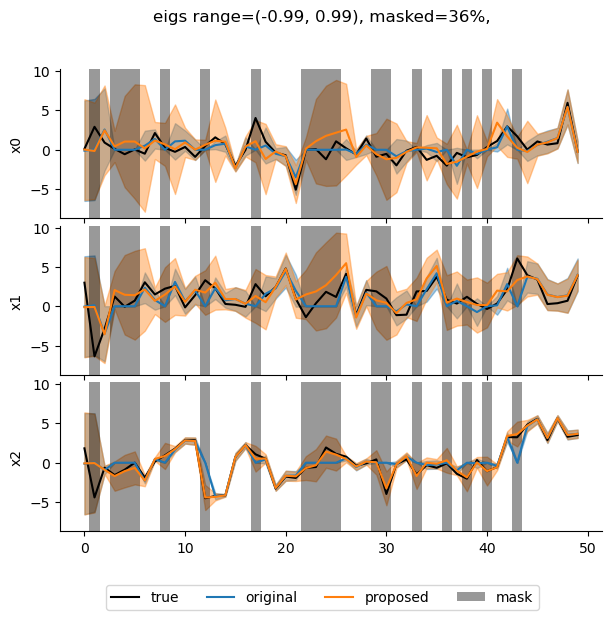

In [10]:
seed = jr.PRNGKey(4392)
num_invalid = 25
num_samples = 1000

dynamics_eigs_range = (-0.99, 0.99)

# -----------------------------------------------------------------------------
xs_original, xs_proposed, (ys, mask), (xs_true, zs_true,) \
        = sample_original_vs_proposed(seed, dynamics_eigs_range, num_invalid)

num_timesteps = len(ys)
fig, axs = plot_mean_variance(xs_original, xs_proposed, xs_true, mask)
fig.suptitle(f'eigs range={dynamics_eigs_range}, masked={(1-mask).sum()/num_timesteps*100:.0f}%,')

# do not assert similarity between xs_original and xs_proposed since they have
# treat masked timesteps differently

## No masked observations, unstable dynamics

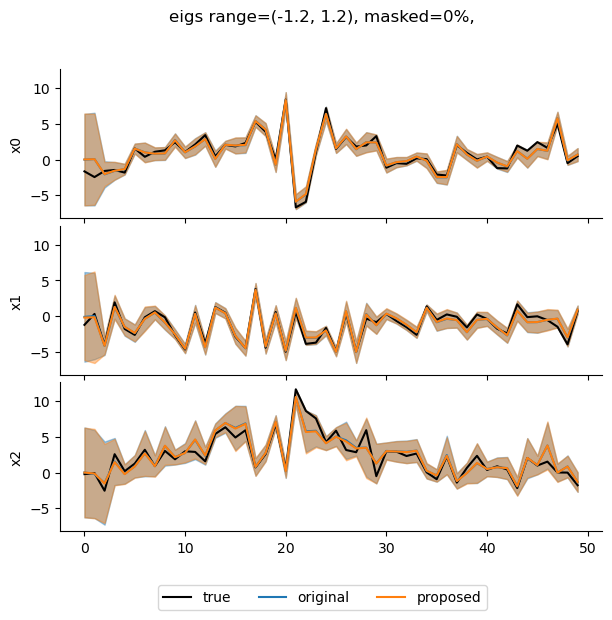

In [16]:
seed = jr.PRNGKey(213)
num_invalid = 0
num_samples = 1000

dynamics_eigs_range = (-1.2, 1.2)

# -----------------------------------------------------------------------------

xs_original, xs_proposed, (ys, mask), (xs_true, zs_true,) \
        = sample_original_vs_proposed(seed, dynamics_eigs_range, num_invalid)

num_timesteps = len(ys)
fig, axs = plot_mean_variance(xs_original, xs_proposed, xs_true, mask)
fig.suptitle(f'eigs range={dynamics_eigs_range}, masked={(1-mask).sum()/num_timesteps*100:.0f}%,')

assert jnp.allclose(xs_original.mean(axis=0), xs_proposed.mean(axis=0), atol=5e-1)

## Masked observations, unstabled dynamics

Text(0.5, 0.98, 'eigs range=(-1.2, 1.2), masked=38%,')

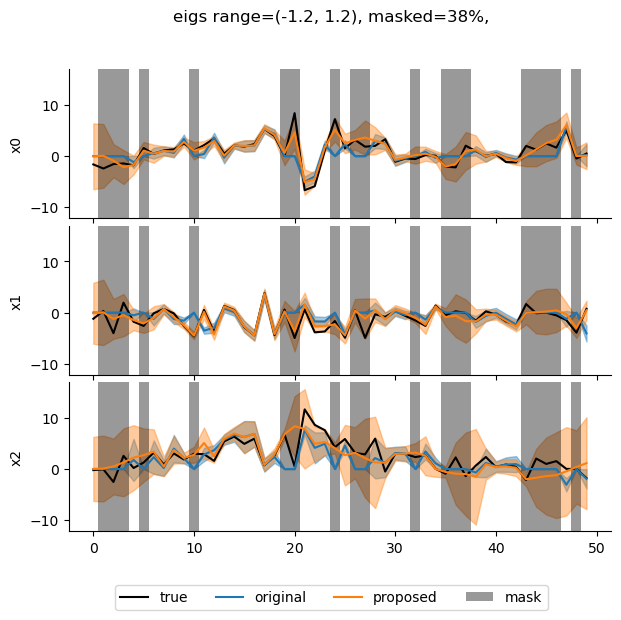

In [14]:
seed = jr.PRNGKey(213)
num_invalid = 25
num_samples = 1000

dynamics_eigs_range = (-1.2, 1.2)

# -----------------------------------------------------------------------------
xs_original, xs_proposed, (ys, mask), (xs_true, zs_true,) \
        = sample_original_vs_proposed(seed, dynamics_eigs_range, num_invalid)

num_timesteps = len(ys)
fig, axs = plot_mean_variance(xs_original, xs_proposed, xs_true, mask)
fig.suptitle(f'eigs range={dynamics_eigs_range}, masked={(1-mask).sum()/num_timesteps*100:.0f}%,')

## Unstable dynamics, masked observations at tail

Text(0.5, 0.98, 'eigs range=(-2.0, 2.0), masked=52%,')

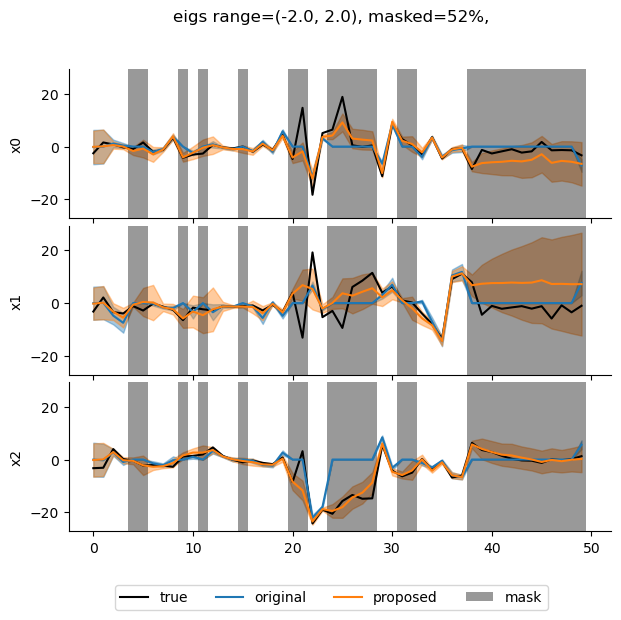

In [15]:
seed = jr.PRNGKey(5220)
seed, seed_mask = jr.split(seed)
num_invalid = 25
num_samples = 1000
num_timesteps = 50
dynamics_eigs_range = (-2., 2.)

mask = sample_mask(seed_mask, num_timesteps, num_invalid)
mask = mask.at[-10:].set(0)

# -----------------------------------------------------------------------------
xs_original, xs_proposed, (ys, mask), (xs_true, zs_true,) \
        = sample_original_vs_proposed(seed, dynamics_eigs_range, num_invalid, num_timesteps=num_timesteps, mask=mask)

num_timesteps = len(ys)
fig, axs = plot_mean_variance(xs_original, xs_proposed, xs_true, mask)
fig.suptitle(f'eigs range={dynamics_eigs_range}, masked={(1-mask).sum()/num_timesteps*100:.0f}%,')
